## Run ANL's LOM: PILOWF

Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to read in inflow data, load obstacle data, and run the LOMs.

Output is saved into files named:

 > `bergey|oneenergy_anl|lanl_tid_windSource_obstacleMode.csv.bz2`, 
 
 > where `windSource` is one of: `wtk`, `wtk_led_2018`, `wtk_led_2019`, `wtk_bc`, `wtk_led_bc` (`bc` referes to bias corrected versions) 
 
 > and `obstacleMode` is one of: `bldgsonly`, `treesasbldgs`, `bldgsandtrees`

### Work notes:

- Currently only ANL model
- Sites t007 and t074 are currently excluded becuase they don't have height data matching other sites
- Code looks for `"%s/%sv2.json" % (obstacle_data_dir, tid)` files for site obstacles inside `02 Input For Models` dir
- Sites t207 take a very long time! (slowest site)
- Notice that based on the plots at the end of the notebook ws-adjusted = ws (exactly) for quite a few sites. No negative ws-adjusted values observed yet for this set of inputs.
- `wind_sources = ["wtk", "wtk_led_2019", "wtk_bc", "wtk_led_bc"]` -- not including "wtk_led_2018" yet becuase 5-minuted data for 2018 is very large and processing will be slower than for other options here; will add it for final/more complete processing
- `overwrite` (if not set) flag allows to skip processing previously studied site x wind_source combinations (if output files with matching names are found)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
import subprocess
import shutil

%matplotlib inline
%config InlineBackend.figure_format='retina'

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Note: APRS ID in this dataset is treated as unique site ID and used throughout this notebook

index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,...,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy,Bergey Annual Average Wind Speed (m/s),Bergey Generation (kWh) (0% Loss Assumption)
0,t007,A2744,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary,6.55,24828
1,t024,A2690,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,5.86,19184
2,t028,A2672,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,4.60,9670
3,t034,A3685,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public,6.55,24828
4,t041,A3933,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN,5.94,19829


### Select which sites need to be processed, wind data sources, and obstacles modes

In [4]:
# Small test with several sites
selected = ["t207"]

# Process all sites:
#selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
#selected = [x for x in selected if not(x in ["t007", "t074"])]

# Remove slowest site for now
#selected = [x for x in selected if not(x in ["t207"])]
print(selected)

# wtk is the main option here
wind_sources = ["wtk_led_bc"] #"wtk_bc"] # Choices here: "wtk", "wtk_led_2018", "wtk_led_2019", "wtk_bc"

obstacle_modes = ["bldgsonly"] #"bldgsonly_100m"] #"bldgsonly", "treesasbldgs"] #, "bldgsandtrees"] # Choices here: `bldgsonly`, `bldgsandtrees`

['t207']


### Load wind data

In [15]:
atmospheric_inputs = {}

for wind_source in wind_sources:

    if wind_source == "wtk":

        wtk_df = pd.read_csv("01 Bergey Turbine Data/wtk.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2018":

        wtk_led_2018 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2018.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2018[wtk_led_2018["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2019":

        wtk_led_2019 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2019.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2019[wtk_led_2019["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
            
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_bc":
        wtk_bc_df = pd.read_csv("02 Bias Correction/wtk_bc.csv.bz2")
        
        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_bc_df[wtk_bc_df["tid"] == tid].reset_index(drop=True)
            
            # Actually use bias corrected wind speeds for further steps (overwrite original ws)
            dfs_by_tid[tid]["ws"] = dfs_by_tid[tid]["ws_bc"]
            
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid
        
    elif wind_source == "wtk_led_bc":
        wtk_led_bc_df = pd.read_csv("02 Bias Correction/wtk_led_bc.csv.bz2")
        #print(wtk_led_bc_df.tid.unique())
        
        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_bc_df[wtk_led_bc_df["tid"] == tid].reset_index(drop=True)
            
            # Actually use bias corrected wind speeds for further steps (overwrite original ws)
            dfs_by_tid[tid]["ws"] = dfs_by_tid[tid]["ws_bc"]
            
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid
        
    else:
        print("Unsupported wind_source selected:", wind_source)

['t034' 't083' 't170']


In [14]:
if "wtk_led_bc" in atmospheric_inputs.keys():
    print(atmospheric_inputs["wtk_led_bc"])

{'t207': Empty DataFrame
Columns: [index, tid, datetime, ws, wd, hour, month, ws_bc]
Index: []}


### Load obstacle data

In [7]:
# Load obstacle and initial filtering; there will be more filtering later depending on the obstacle_mode

sites_with_tall_blgs = [] 

obstacle_inputs = {}
for tid in selected:
    #print("Processing tid: ", tid)
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    
    if os.path.exists(obstacle_data_file):
        #print("BEFORE filtering (%s):" % obstacle_data_file)
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid,
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        obstacle_df["tid"] = tid
        obstacle_inputs[tid] = obstacle_df
        
        #print("AFTER filtering (%s):" % obstacle_data_file)
        #display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

all_obstacle_inputs = pd.concat(obstacle_inputs.values())
display(all_obstacle_inputs)

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t207) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
600  60.192749     building  POLYGON ((-87.71964 41.48273, -87.71967 41.482...
601  41.273163     building  POLYGON ((-87.71890 41.48356, -87.71900 41.483...
614  54.781128     building  POLYGON ((-87.71809 41.48179, -87.71801 41.482...
759  47.655518         tree  POLYGON ((-87.72349 41.48257, -87.72351 41.482...
765  38.942688         tree  POLYGON ((-87.72415 41.48270, -87.72418 41.482...
773  50.096558         tree  POLYGON ((-87.72254 41.48327, -87.72256 41.483...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \


,height,geometry,feature_type,tid
0,10.784363,"POLYGON ((-87.72487 41.48525, -87.72487 41.484...",building,t207
1,15.239929,"POLYGON ((-87.72807 41.48813, -87.72827 41.488...",building,t207
2,16.842346,"POLYGON ((-87.72643 41.48322, -87.72643 41.483...",building,t207
3,18.385254,"POLYGON ((-87.72490 41.48352, -87.72490 41.483...",building,t207
4,15.265625,"POLYGON ((-87.72452 41.48386, -87.72460 41.483...",building,t207
...,...,...,...,...
769,7.992371,"POLYGON ((-87.72387 41.48420, -87.72387 41.484...",tree,t207
770,19.667358,"POLYGON ((-87.72386 41.48391, -87.72387 41.483...",tree,t207
771,35.020996,"POLYGON ((-87.72253 41.48355, -87.72256 41.483...",tree,t207
772,35.074890,"POLYGON ((-87.72253 41.48341, -87.72254 41.483...",tree,t207


In [8]:
# Save combined and filtered obstacles dataframe into a file
#obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
#dest_file = "%s/all_obstacles.json" % (obstacle_data_dir)
#all_obstacle_inputs.to_file(dest_file, driver="GeoJSON", index=False)

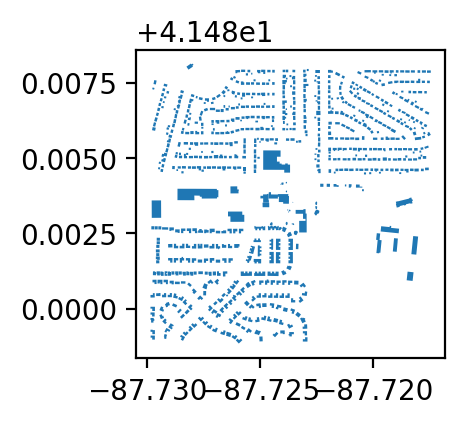

In [9]:
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot(figsize=(2,2))

### Run ANL's LOM

In [10]:
# Old code; replaced with the parallel version below

# Working sequential version -- one site at a time

# # This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
# overwrite = False

# # Will be used in the filenames
# site_type = "bergey"

# # Will be used in the filenames
# model_type = "anl"

# dest_dir = "03 Model Outputs"
# if not os.path.exists(dest_dir):
#     os.makedirs(dest_dir)    
    
# for tid in tqdm(selected):
    
#     for wind_source in wind_sources:
        
#         for obstacle_mode in obstacle_modes:
        
#             dest_filename = "%s/%s_%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source, obstacle_mode)
            
#             if (not overwrite) and (os.path.exists(dest_filename)):
#                 print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
#             else:
#                 row = index[index["APRS ID"] == tid].iloc[0]
#                 #print(row)
#                 lat = row["Latitude"]
#                 lon = row["Longitude"]
#                 z_turbine = row["Hub Height (m)"]
#                 xy_turbine = [np.array([lon, lat])]

#                 if obstacle_mode == "bldgsonly":
#                     obs_df = obstacle_inputs[tid]
#                     obs_df = obs_df[obs_df["feature_type"] == "building"].reset_index(drop=True)
#                 elif obstacle_mode == "bldgsandtrees":
#                     # Assume trees pass the filtering run above in this notebook 
#                     obs_df = obstacle_inputs[tid]
                
#                 predictions_df = run_lom(atmospheric_inputs[wind_source][tid], \
#                                          obs_df, \
#                                          xy_turbine, z_turbine, \
#                                          check_distance=True)

#                 # Add LOM output back to the more complete input dataframe
#                 atmospheric_inputs[wind_source][tid]["ws-adjusted"] = predictions_df["ws-adjusted"]   
#                 atmospheric_inputs[wind_source][tid].to_csv(dest_filename, index=False)

In [11]:
# Prepare files for PILOWF + multiprocessing & run LOM

# Parallelizing: the code here runs multiple TIDs at the same time; single TID -- no parallelism

# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = True

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "anl"

dest_dir = "01 Bergey Turbine Data/pilowf_inputs/"

script_path = "./run_pilowf_mp.py"
    
for wind_source in wind_sources:

    for obstacle_mode in obstacle_modes:

        # Make sure to start from scratch and not reuse previously saved inputs
        if os.path.exists(dest_dir):
            shutil.rmtree(dest_dir, ignore_errors=True)
        os.makedirs(dest_dir)    
        
        for tid in selected:
            row = index[index["APRS ID"] == tid].iloc[0]
            #print(row)
            lat = row["Latitude"]
            lon = row["Longitude"]
            z_turbine = row["Hub Height (m)"]
            xy_turbine = [np.array([lon, lat])]

            if obstacle_mode == "bldgsonly":
                obs_df = obstacle_inputs[tid]
                obs_df = obs_df[obs_df["feature_type"] == "building"].reset_index(drop=True)
            elif obstacle_mode == "bldgsandtrees":
                # Assume trees pass the filtering run above in this notebook  
                obs_df = obstacle_inputs[tid]
            elif obstacle_mode == "treesasbldgs":
                # Assume trees pass the filtering run above in this notebook 
                obs_df = obstacle_inputs[tid]  
            elif obstacle_mode == "bldgsonly_100m":
                # Assume trees pass the filtering run above in this notebook 
                obs_df = obstacle_inputs[tid].copy()

                print("# of obs (before 100m filtering):", len(obs_df))
                obs_df = filter_obstacles(tid,
                                          obs_df,
                                          include_trees=False, 
                                          turbine_height_for_checking=z_turbine,
                                          limit_to_radius_in_m=100.0,
                                          turbine_lat_lon=(lat, lon))
                print("# of obs (after 100m filtering):", len(obs_df))
                
            elif obstacle_mode == "treesasbldgs_100m":
                # Assume trees pass the filtering run above in this notebook 
                obs_df = obstacle_inputs[tid].copy()

                print("# of obs (before 100m filtering):", len(obs_df))
                obs_df = filter_obstacles(tid,
                                          obs_df,
                                          include_trees=True, 
                                          turbine_height_for_checking=z_turbine,
                                          limit_to_radius_in_m=100.0,
                                          turbine_lat_lon=(lat, lon))
                print("# of obs (after 100m filtering):", len(obs_df))
            
            
            if len(obs_df) == 0:
                print("tid=%s: Obstacle set is empty after filtering. ws-adjusted=ws for this cases." % tid)
            # obs_df.to_file() breaks if empty 
            
                output_dest = "03 Model Outputs/%s_%s_%s_%s_%s.csv.bz2" % (site_type, model_type, tid, wind_source, obstacle_mode)
                
                if (not overwrite) and (os.path.exists(output_dest)):
                    print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
                else:
                    res = atmospheric_inputs[wind_source][tid].copy()
                    res["ws-adjusted"] = res["ws"]
                    res.to_csv(output_dest, index=False)  
                    print("Saved output:", output_dest)

                # Skip the following and go to the next tid x obstacle_mode combination
                continue
            
            
            # Save inputs for PILOWF into separate files
            obs_df.to_file("%s/%s-obstacles.json" % (dest_dir, tid),\
                           driver="GeoJSON", index=False)
            atmospheric_inputs[wind_source][tid].to_csv("%s/%s-atmospheric.csv.bz2" % (dest_dir, tid), index=False)
        
        # It is expecteed that inputs_dir now has a set of individual inputs (atmosperic file and obstacle file for each tid)
        
        # Must use subprocess as a way of wrapping/calling the python script becuase that script uses multiprocessing
        # and other methods seem to break
        # "<TID>" in "--output_filename_pattern" will replaces with actual TIDs inside the script with parallel processing
        
        subprocess.run(["python", script_path,
                    "--inputs_dir", dest_dir, \
                    "--index_file", "01 Bergey Turbine Data/bergey_sites.csv", \
                    "--output_filename_pattern", \
                        "03 Model Outputs/%s_%s_%s_%s_%s.csv.bz2" % (site_type, model_type, "<TID>", wind_source, obstacle_mode), \
                    "--procs", "8"],
                   #stdout=subprocess.DEVNULL, # This addition suppresses entire (lengthy) output
                   cwd="./")

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-06-15 09:15:06.044319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146:

Done with loading ML model.


Runtime: 13.96 (s)


In [12]:
# Update this to look at the latest result
res = pd.read_csv("03 Model Outputs/bergey_anl_t207_wtk_led_bc_bldgsonly.csv.bz2")
res

,index,tid,datetime,ws,wd,hour,month,ws_bc,ws-adjusted


In [17]:
# Quick analysis

# Delta
(res["ws-adjusted"] - res["ws"]).sort_values()

58131    0.000000
48389    0.000000
23809    0.000000
23808    0.000000
37033    0.000000
           ...   
48215    3.946948
55219    4.223093
25777    4.396666
20743    4.618658
60311    6.068854
Length: 61368, dtype: float64

In [ ]:
# Check one case and confirm that there is indeed difference between
# bldgsonly and bldgsandtrees

# f1 = "03 Model Outputs/bergey_anl_t034_wtk_bc_bldgsonly.csv.bz2"
# df1 = pd.read_csv(f1)
# df1

# f2 = "03 Model Outputs/bergey_anl_t034_wtk_bc_bldgsandtrees.csv.bz2"
# df2 = pd.read_csv(f2)
# df2

# Looking for non-zero mean here to see the difference between two outputs
# (df2["ws-adjusted"] - df1["ws-adjusted"]).mean()

In [ ]:
# Quick vis of data in produced files

# for f in glob.iglob("%s/*" % dest_dir):
#     df = pd.read_csv(f)
#     fig = plt.gcf()
#     fig.set_size_inches(2.5,2.5)
#     sns.scatterplot(x=df["ws"], \
#                     y=df["ws-adjusted"], alpha=0.2).set(title=os.path.basename(f));
#     plt.show()